In [1]:
import time

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from utils.utils import find_Q_hat
from ThreshDetection.thresh import ThreshAnalytical
from utils.hmatr import Hmatr
from utils.utils import generate_series, find_fpr_corr_to_thresh

Unable to determine R home: [WinError 2] Не удается найти указанный файл
Unable to determine R library path: Command '('D:\\Program Files\\R\\R-4.1.3\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.
R[write to console]: Warning:
R[write to console]:  package 'Rssa' is in use and will not be installed



In [22]:
# Parameters
# Fixing: N = 700, w1 = 1 / 10, w_min = w1 + 1 / 100, k = 30, w2 = 1 / 5, Q = 301, noise_sd = 0.5, iter_num = 200
N = 700  # Длина ряда
w1 = 1 / 10  # Начальная частота
w_min = w1 + 1 / 100  # Минимальная разница в частотах для обнаружения неоднородности
k = 30  # Кол-во точек, за которые нужно обнаружить разладку
w2 = w1 + 1 / 100
Q = 301
r = 2
method = "svd"
noise_sd = 0.5
B = 100
T_ = 100
L = 80
iter_num = 200

In [23]:
def modelling_series():
    np.random.seed(12345)
    series = []
    rows = []
    time_start = time.time()
    for i in tqdm(range(iter_num)):
        original_series = generate_series(w1, w2, Q, N)
        noise = np.random.randn(N) * noise_sd ** 2
        original_series += noise
        hm = Hmatr(f=original_series, B=B, T=T_, L=L, neig=r, svdMethod=method)
        rows.append(hm.getRow(sync=True))
        series.append(original_series)
    print(f"Modelling took {round(time.time() - time_start, 4)} s")
    return series, rows

In [24]:
print(f"Params: w1 = {w1}, w2 = {w2}, w_min = {round(w_min, 5)}, L = {L}, k = {k}, T = {T_}")

Params: w1 = 0.1, w2 = 0.11, w_min = 0.11, L = 80, k = 30, T = 100


In [ ]:
modelled_series, modelled_rows = modelling_series()

In [83]:
threshes = np.arange(0, 1.01, 0.01)

fpr = []  # Детекции раньше настоящего момента возмущения
tpr = []  # Детекции в или позже момента возмущения, но не позже момента k
tpr_1 = []  # Детекции в или позже момента возмущения, но не позже момента k

Q_hats = []
time_start = time.time()
for thresh in threshes:
    fp = 0
    tp = 0
    tp_1 = 0
    for row in modelled_rows:
        Q_hat = find_Q_hat(row, thresh)
        Q_hats.append(Q_hat)
        if Q_hat is None:
            # Не превзошли порог, пропускаем значение. При подсчете долей кривые будут уходить в 0
            continue
        if Q_hat < Q:
            fp += 1
        if Q <= Q_hat <= Q + k:
            tp += 1
    fpr.append(round(fp/iter_num, 4))
    tpr.append(round(tp/iter_num, 4))

g_analytical = ThreshAnalytical(w1, w_min, L, T_, k)

print(f"Calculating statistics took {round(time.time() - time_start, 4)} s")

Calculating statistics took 0.384 s


C:\Users\ivank\AppData\Local\Temp\ipykernel_7952\2818027675.py:5: RuntimeWarning: invalid value encountered in true_divide
  values = np.array(tpr/(1-np.array(fpr)))


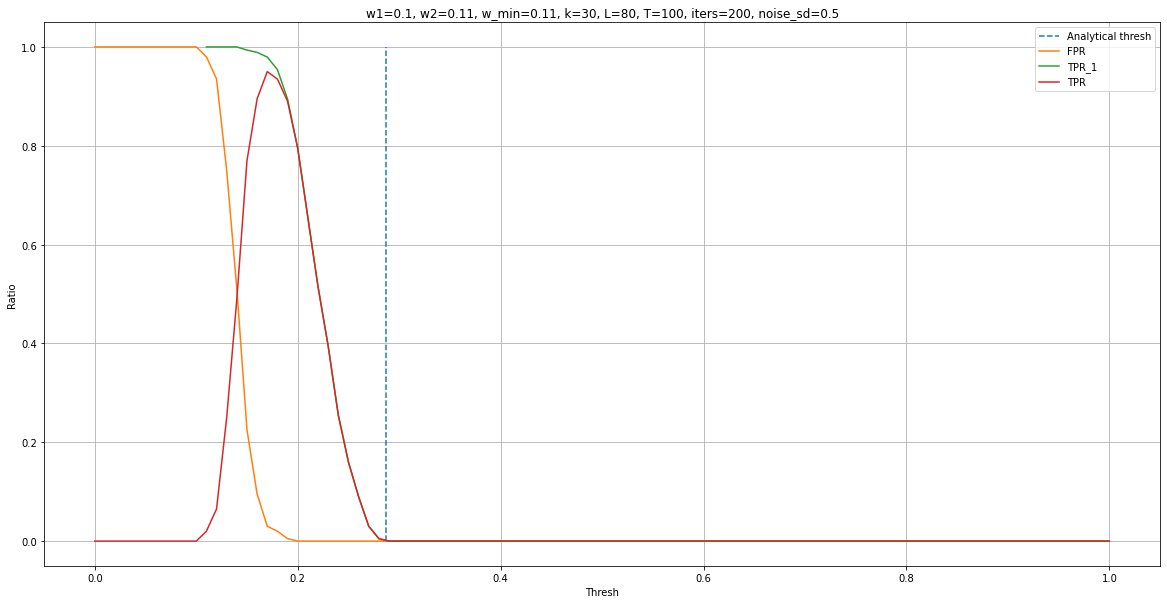

FPR corresponding to analytical thresh: 0.0


In [84]:
plt.figure(figsize=(20, 10))
plt.plot([g_analytical.thresh]*len(threshes), threshes, '--', label='Analytical thresh')
plt.plot(threshes, fpr, label='FPR')

values = np.array(tpr/(1-np.array(fpr)))
idxs = np.invert(np.isnan(values))
values = values[idxs]
plt.plot(np.array(threshes)[idxs], values, label='TPR_1')

plt.plot(threshes, tpr, label='TPR')
plt.title(f"w1={w1}, w2={w2}, w_min={round(w_min, 4)}, k={k}, L={L}, T={T_}, iters={iter_num}, noise_sd={noise_sd}")
plt.xlabel('Thresh')
plt.ylabel('Ratio')
plt.legend()
plt.grid()
plt.show()

fpr_to_thresh = find_fpr_corr_to_thresh(threshes, fpr, g_analytical.thresh)
print(f"FPR corresponding to analytical thresh: {fpr_to_thresh}")